# REFERENCE - benchmark structural regression

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from Bio import SeqIO
from pathlib import Path
sns.set_theme(style="white", context="talk")
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import itertools
from scipy import stats



from utils_benchmark import * 
#test()

sns.set_context("talk")


def get_stats(scores_df, summary_homfam_exthomfam):
    stats_alignments = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val", "align_method", "tree_method"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["approach"] = stats_alignments.approach.apply(lambda val: val.replace("_nan",""))
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [2]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/"
# Load reference stats 
stats_alignments_ref= pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"))
summary_homfam_merged_tosave = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))

# Extract AF2 info for references only # Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
# Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})


In [3]:
# Extract all sequences in reference 
summary_ref_af2 = pd.DataFrame()
for f in listdir(seqs_dir):
     if f.endswith("fa"):
        fasta_sequences = SeqIO.parse(open(os.path.join(seqs_dir,f)),'fasta')
        for fasta in fasta_sequences:
            seq_id = [fasta.id.replace("/","_")]
            l = len(fasta.seq.replace("-", ""))
            entry = pd.DataFrame({'sequence': seq_id,"length":l, "name": [f.replace("-ref.fa","").strip()]})
            summary_ref_af2 =  pd.concat([summary_ref_af2, entry], ignore_index = True)
summary_ref_af2["subset"] = "ref"
summary_ref_af2["family"] = summary_ref_af2.name
summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
af2_homfam_summary = summary_ref_af2.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)

summary_homfam_merged_tosave["family"] = summary_homfam_merged_tosave.familcombined
summary_ref = pd.merge(summary_homfam_merged_tosave,af2_homfam_summary)

# plddt of ALL reference seqs

Text(0.5, 0.98, 'n=772')

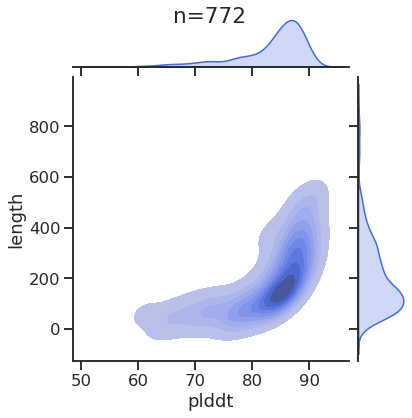

In [4]:
sns.set_theme(style="ticks")
sns.set_context("talk")


ax = sns.jointplot(
    data=summary_ref_af2,  fill=True, color = "royalblue", legend = False, 
    x="plddt", y="length",
    kind="kde"
)

nobs = summary_ref_af2['sequence'].value_counts().sum()

# Add it to the plot
#ax.fig.text(1,1,nobs,horizontalalignment='center',size='small',color='red')
ax.fig.suptitle("n="+str(nobs))

# Load references MSAs 

In [5]:
# Define dataset 
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    # Parse file
    if score_file.endswith(".scores"):
        # only keep references
        if "-ref" in score_file:
            score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
            scores = pd.concat([scores, score_df])
scores = scores.iloc[:,0:4]
scores.columns = ['name', 'sp', 'tc', 'column']

# Extract subsets of interest

In [6]:
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)


# --------------   summary all -----------------
scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)

scores_df.family = scores_df.family.str.replace("-ref","")
scores_df["benchmarking_dataset"] = dataset

stats_alignments_ref = get_stats(scores_df, summary_homfam_exthomfam)

df = stats_alignments_ref
df.nref = df.n_sequences * df.perc_ref_total /100 

df = pd.merge(df, summary_ref, on = "family")

/tmp/ipykernel_37384/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_37384/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_37384/3451490122.py:5: SettingWithCopyWarning: 

In [7]:
# Comparison 1: DYNAMIC w/ 3D
df_dyn_3d = df[df.approach == "dynamic_50_tcoffee_msa_famsa_msa_100000000_FAMSA-medoid"]
#df_dyn_3d["nref"] = df_dyn_3d.n_sequences * df_dyn_3d.perc_ref_total /100 

# Comparison 2: DYNAMIC w/ FAMSA 
df_dyn_famsa = df[df.approach == "dynamic_50_famsa_msa_famsa_msa_100000000_FAMSA-medoid"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d = df[df.approach == "progressive_3DCOFFEE_FAMSA-medoid"]
df_prog_3d_mbed = df[df.approach == "progressive_3DCOFFEE_MBED"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d_probapair = df[df.approach == "progressive_PROBAPAIR_FAMSA-medoid"]
df_prog_3d_probapair_mbed = df[df.approach == "progressive_PROBAPAIR_MBED"]

# For sanity checks, MBED 
# df_prog_3d_expresso = df[df.approach == "progressive_EXPRESSOREAL_MBED"]
df_prog_3d_expresso = df[df.approach == "progressive_3DCOFFEEEXPERIMENTAL_MBED"]
df_prog_3dcoffee = df[df.approach == "progressive_3DCOFFEE_MBED"]
df_prog_famsa = df[df.approach == "progressive_FAMSA_MBED"]


# Comparison 4: PROGRESSIVE w/ FAMSA
df_prog_famsa_medoid = df[df.approach == "progressive_FAMSA_FAMSA-medoid"]


df_d_r = pd.merge(df_prog_3dcoffee, df_prog_3d_probapair_mbed, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 
df_d_r.columns = [c.replace("_x", "_3D") for c in list(df_d_r.columns)]
df_d_r.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r.columns)]



df_d_r_exp = pd.merge(df_prog_3d_expresso, df_prog_3d_probapair_mbed, on = ["family"] )
df_d_r_exp["diff_tc"] = df_d_r_exp.tc_x - df_d_r_exp.tc_y 
df_d_r_exp["diff_sp"] = df_d_r_exp.sp_x - df_d_r_exp.sp_y 
df_d_r_exp["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r_exp.tc_y) 
df_d_r_exp.columns = [c.replace("_x", "_3D") for c in list(df_d_r_exp.columns)]
df_d_r_exp.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r_exp.columns)]

# BUG SANITY CHECK 

#### Separate the exact classes we want the comparison with 

In [8]:
df = pd.concat([df_dyn_3d, df_dyn_famsa, df_prog_3d, df_prog_famsa])

#### Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)

In [9]:
# Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)
df_dyn_3d_red = df_dyn_3d[["family","tc"]]
df_prog_3d_red = df_prog_3d[["family", "tc"]]
df_3d_all = pd.merge(df_dyn_3d_red, df_prog_3d_red, on = "family")
#np.array(df_3d_all.tc_x == df_3d_all.tc_y)

#### Do 3D COFFEE and 3D PROBAPAIR give the same?  no (aka --> WE ARE USING THE STRUCTURES)


In [10]:
# Do 3D COFFEE and 3D PROBAPAIR give the same?  no (aka --> WE ARE USING THE STRUCTURES)
df1_red = df_dyn_3d[["family","tc"]]
df2_red = df_prog_3d_probapair[["family", "tc"]]
df_all = pd.merge(df1_red, df2_red, on = "family")
#np.array(df_all.tc_x == df_all.tc_y)

In [11]:
# Do 3D progressive and 3D dyanmic give the same : we are using different trees options! 
# Take a decision on what to keep and mae it consistent!!
df_dyn_famsa_red = df_dyn_famsa[["family","tc"]]
df_prog_famsa_red = df_prog_famsa[["family", "tc"]]
df_famsa_all = pd.merge(df_dyn_famsa_red, df_prog_famsa_red, on = "family")
#np.array(df_famsa_all.tc_x ==df_famsa_all.tc_y)

# TC SANITY CHECK 

## With my approach I cannot retrieve the same templates 

In [12]:
# Check which structures are getting used in Expresso 
templates = pd.DataFrame()
# Collect templates
for name in glob.glob('/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/structures/search_hits/mmseqs/*-ref/*/template.txt'):
    fam_name_complete= name.split("/")[-3]
    family = fam_name_complete.replace("-ref", "")
    template_df = pd.read_csv(name, sep = " ", header = None)
    ntemplate = len(template_df.index)
    new_row = pd.DataFrame({"family_complete":[fam_name_complete], "family": [family],'ntemplates':[ntemplate]})
    templates = pd.concat([templates,new_row])
# Per family check the number of structures in template
# pd.merge(summary_ref,templates, on  = "family")[["family", "n_sequences_ref", "ntemplates"]]

# How is 3D+AF2 doing on the references? 


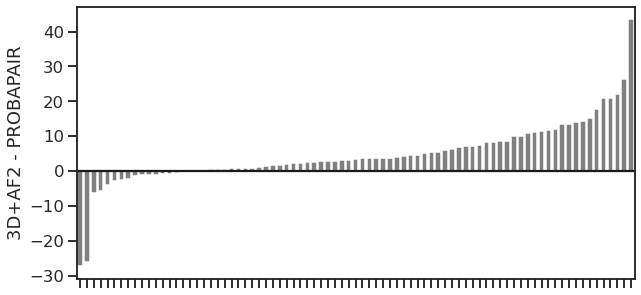

In [13]:
f, (ax1) = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_sp, y=df_d_r.diff_sp, color ="grey", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="3D+AF2 - PROBAPAIR", xlabel = "", xticklabels="")
plt.show()

### For some families, we are not as good as with probapair when including the structural information.

# GDT TS 

## Parse GDT_TS and check for which families we retrieve ALL the structures

In [14]:
# Collect all the gdt files 
gdt_summary = pd.DataFrame()
for file in glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/pdbs/structures/eval_gdt/*/*.txt"):
    gdt = pd.read_csv(file, header = None)
    gdt_summary = pd.concat([gdt_summary, gdt])
gdt_summary = gdt_summary.rename(columns={0: "family", 1: "sequence", 2: "metric", 3: "value"})
gdtss = gdt_summary[gdt_summary["metric"] == "GDT-TS"]
gdtss = gdtss.groupby(['family']).agg({'value': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "gdt_mean", "gdt_min", "gdt_max"], axis=1)
gdtss["gdt_mean"] = gdtss["gdt_mean"].astype("float") * 100
gdtss["gdt_min"] = gdtss["gdt_min"].astype("float") * 100 
gdtss["gdt_max"] = gdtss["gdt_max"].astype("float") * 100

# Add GDT to the df 
df_d_r_wgdt = df_d_r.merge(gdtss, on = "family")
df_d_r_wgdt["sp_3D"] = df_d_r_wgdt["sp_3D"].astype(float)
df_d_r_wgdt["tc_3D"] = df_d_r_wgdt["tc_3D"].astype(float)
msa_qualities = df_d_r_wgdt[["family", "sp_3D", "tc_3D"]]

# Check the amount of matches after filtering mmseqs
mmseqs_summary = pd.DataFrame()
for file in glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/pdbs/structures/search_hits/mmseqs/*/*/filtered_hits.m8"):
    family = os.path.basename(os.path.dirname(file)).replace("-ref.PDB", "")
    with open(file, 'r') as fp:
        nhits = len(fp.readlines())
    entry = pd.DataFrame({'family':[family], 'nhits': nhits})
    mmseqs_summary =  pd.concat([mmseqs_summary, entry], ignore_index = True)
    
# Check that I am extracting all the references 
n_ref_structures  = gdt_summary[gdt_summary["metric"] == "GDT-TS"].groupby(['family']).agg({'sequence': ['count']}).reset_index().set_axis(["family", "n_ref_structures"], axis = 1)
df_test = df_d_r.merge(n_ref_structures, on = "family", how = "left")
df_test = df_test[["family","n_sequences_ref_3D", "n_ref_structures"]]
df_test = df_test.merge(mmseqs_summary, on = "family", how = "left")
df_test = df_test.replace(np.nan, 0)

In [15]:
# 1. Quantify the loss in number of sequences and make sure is due to the mmseqs not 100% hit ( check and parse filter hits file)
#    First the mmseqs sanity check --> needs to be empty. If full, the reported family is problematic.
df_test[(df_test.n_sequences_ref_3D > df_test.n_ref_structures) & ( df_test.n_ref_structures < df_test.nhits)]
# How many sequences per family do I loose? 
df_test["loss"] = df_test.n_sequences_ref_3D - df_test.n_ref_structures
df_test.loss.sum()
# What I want to know 
# 1 - total % of loss 
total_amount_references = df_test.n_sequences_ref_3D.sum()
references_with_experimental_structure = df_test.n_ref_structures.sum()
print("Total number of reference sequences in Homfam: " + str(total_amount_references))
print("Total number of retrieved structures: " + str(references_with_experimental_structure))
print("Sequences with missing structures: "+ str(total_amount_references - references_with_experimental_structure))
print("% loss: "+ str((total_amount_references - references_with_experimental_structure)*100/total_amount_references))
# And also the %of loss (and absolute numbers) per family 
df_test["perc_loss"] = df_test.loss*100/df_test.n_sequences_ref_3D
df_test["loss"] = df_test["loss"].astype(float)
df_test["perc_loss"] = df_test["perc_loss"].astype(float)

Total number of reference sequences in Homfam: 780
Total number of retrieved structures: 723.0
Sequences with missing structures: 57.0
% loss: 7.3076923076923075


24


[Text(0.5, 0, '% of ref missing structure')]

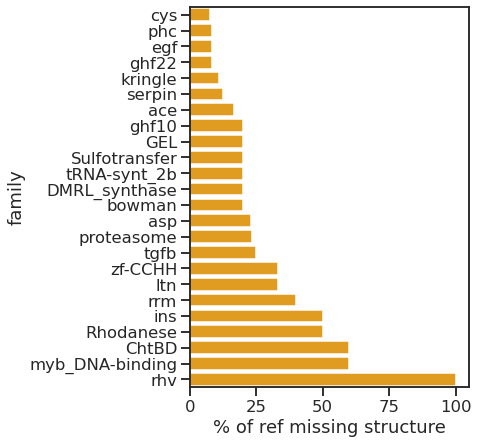

In [16]:
# In how many families do I loose at least one structure? 
df_test_loss = df_test[df_test.loss > 0]
df_test_loss = df_test_loss.sort_values(by='perc_loss', ascending=True)
print(df_test_loss.family.count())
df_test_loss[df_test_loss.perc_loss > 30].family.count()
familes_no_loss = list(df_test[df_test.loss == 0].family)

plt.figure(figsize=(5,7))
ax= sns.barplot(x='perc_loss', y='family', data=df_test_loss, ci=None, color = "orange")
ax.set(xlabel='% of ref missing structure')

# EVALUATE 3D based alignments
### In the 70 families where I can find all the experimental structures


In [17]:
# We only keep the families that have no loss in strucures, otherwise it makes no sense the comparison
df_prog_3d_expresso_noloss = df_prog_3d_expresso[df_prog_3d_expresso.family.isin(familes_no_loss)]
df_prog_3d_probapair_mbed_noloss = df_prog_3d_probapair_mbed[df_prog_3d_probapair_mbed.family.isin(familes_no_loss)]
df_prog_3dcoffee_noloss = df_prog_3dcoffee[df_prog_3dcoffee.family.isin(familes_no_loss)]
df = pd.concat([df_prog_3d_expresso_noloss,df_prog_3d_probapair_mbed_noloss])
df = pd.concat([df,df_prog_3dcoffee_noloss])
df["sp_max"] = df.groupby(['family'])['sp'].transform(max)
df = df.sort_values("sp_max")


df_exp_3d = pd.merge(df_prog_3d_expresso_noloss, df_prog_3dcoffee_noloss, on = ["family"] )
df_exp_3d["diff_tc"] = df_exp_3d.tc_x - df_exp_3d.tc_y 
df_exp_3d["diff_sp"] = df_exp_3d.sp_x - df_exp_3d.sp_y 
df_exp_3d["perc_change_tc"]= df_exp_3d.diff_tc *100/ abs(df_exp_3d.tc_y) 
df_exp_3d.columns = [c.replace("_x", "_EXP") for c in list(df_exp_3d.columns)]
df_exp_3d.columns = [c.replace("_y", "_3D") for c in list(df_exp_3d.columns)]

In [18]:
columns_to_keep = ["family", "sp", "align_method", "sp_max"]
test = df[columns_to_keep]
best_fams = test[test.sp == test.sp_max].groupby("family").first().reset_index()[["family", "align_method"]]
best_fams  = best_fams.rename(columns = {"align_method": "best_method"})
df = df.merge(best_fams, on = "family")

In [19]:
# Separate for when who is doing better 
df_3dwins = df[df.best_method == "3DCOFFEE"]
df_probawins = df[df.best_method == "PROBAPAIR"]
df_expwins = df[df.best_method == "3DCOFFEEEXPERIMENTAL"]

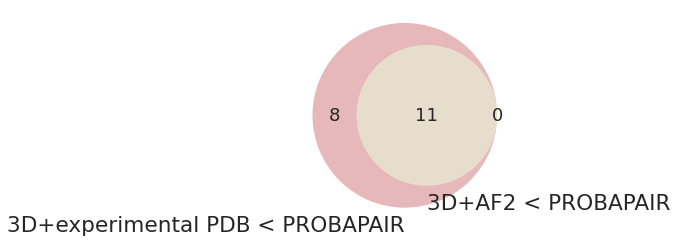

In [20]:
## When we are doing worse than FAMSA, is it the quality of the structure? 
df_expresso_famsa = pd.merge(df_prog_3d_expresso_noloss, df_prog_3d_probapair_mbed_noloss, on = ["family"] )
df_dynamic_famsa = pd.merge(df_prog_3dcoffee_noloss,df_prog_3d_probapair_mbed_noloss, on = ["family"] )
df_dynamic_famsa = df_dynamic_famsa[df_dynamic_famsa.family.isin(list(df_expresso_famsa.family))]
expresso_less_famsa = list(df_expresso_famsa[df_expresso_famsa.sp_x < df_expresso_famsa.sp_y ]["family"])
dynamic_less_famsa = list(df_dynamic_famsa[df_dynamic_famsa.sp_x < df_dynamic_famsa.sp_y ]["family"])
set1 = set(expresso_less_famsa)
set2 = set(dynamic_less_famsa)
venn2([set1, set2], ('3D+experimental PDB < PROBAPAIR', '3D+AF2 < PROBAPAIR'))
plt.show()

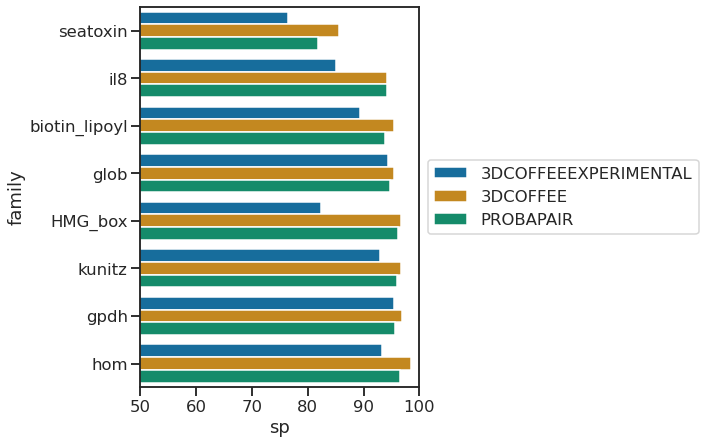

In [21]:
expresso_looses_fully = set1.difference(set2)

plt.figure(figsize=(5,7))
ax= sns.barplot(x='sp', y='family', data=df[df.family.isin(expresso_looses_fully)], ci=None, hue = "align_method", dodge = True, palette = "colorblind")
ax.set(xlim = (50,100))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

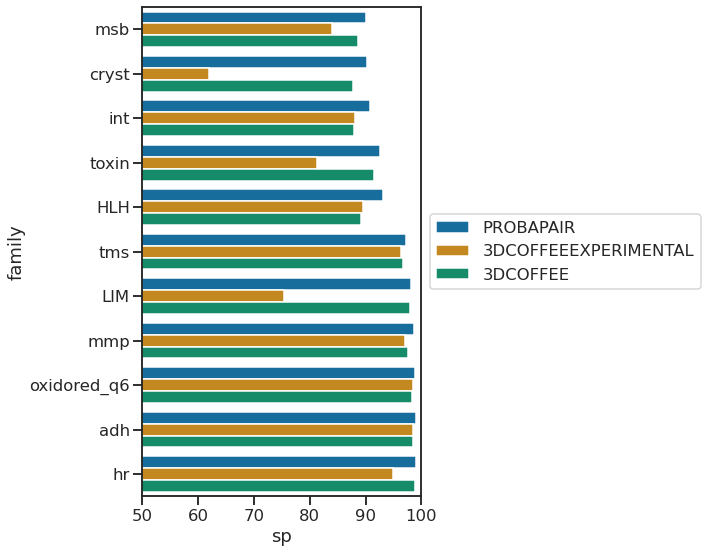

In [22]:
expresso_af2_loose = set1.intersection(set2)


plt.figure(figsize=(5,9))
ax= sns.barplot(x='sp', y='family', data=df[df.family.isin(expresso_af2_loose)], ci=None, hue = "align_method", dodge = True, palette = "colorblind")
ax.set(xlim = (50,100))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Investigate one example

In [ ]:
# Investigate one example
family_inv = "cryst"
df[df.family == family_inv][["name", "sp"]]

In [ ]:
df = pd.concat([df_prog_3dcoffee,df_prog_3d_probapair_mbed])
df[df.family == family_inv]

In [ ]:
gdt_summary[(gdt_summary.family == family_inv) & (gdt_summary.metric == "GDT-TS") ]

In [ ]:
summary_ref_af2[summary_ref_af2.family == family_inv]

In [ ]:
tcs_wf_summary

In [ ]:
tcs_wf_summary[tcs_wf_summary.family == family_inv]

# Alignment with experimental structures are worse 

In [ ]:
# 3D experimental vs AF2 structure 

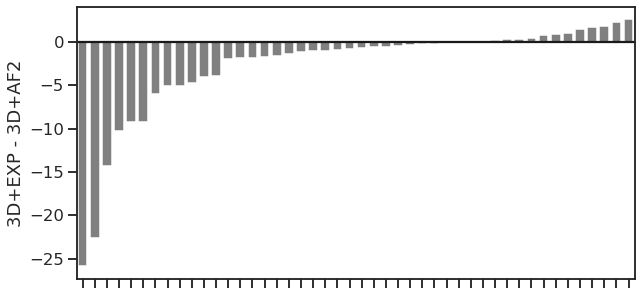

In [23]:
f, (ax2) = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
sns.barplot(x=df_exp_3d.diff_sp, y=df_exp_3d.diff_sp, color ="grey", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set(ylabel="3D+EXP - 3D+AF2", xlabel = "", xticklabels="")
plt.show()

In [ ]:
# Which are here the problematic families in 3D+AF2? 
# They already have very hard to improve values!

### Exploration - why could that happen? 

<AxesSubplot:xlabel='diff_qualitatively', ylabel='plddt_mean_3D'>

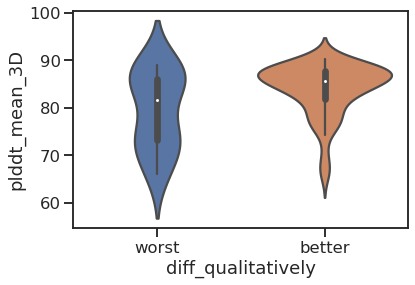

In [24]:
# Which are the ones for which we do not get ? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()

sns.violinplot(data = df_d_r, y = "plddt_mean_3D", x = "diff_qualitatively")

# General metrics exploration

## Load % identity and TCS 

In [231]:
# ---------------------------------------------------------
# Get SIMILARITY per family 
# Get number of sequences per family (and store for future notebooks)
# ---------------------------------------------------------

sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*.sim")
sim_df = pd.DataFrame()

for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

# ---------------------------------------------------------
# Get TCS (and store for future notebooks) 
# ---------------------------------------------------------

tcss = os.path.join(evaluation_dir,"homfam/evaluation/tcs/*.tcs")
tcs_paths = list(glob.glob(tcss))
tcs_df = pd.DataFrame()
tcs_df_complete = tcs_df
for file in tcs_paths:
    full_name = file.split(sep = "/")[-1].replace(".tcs", "")
    file_opened = open(file, "r")
    tot_line = [line.split(sep = "=") for line in file_opened if line.startswith('SCORE')]
    entry = pd.DataFrame({'name': [full_name],"tcs_tot": tot_line[0][1].strip()})
    tcs_df =  pd.concat([tcs_df, entry], ignore_index = True)

In [232]:
tcs_df_complete

""


In [233]:
# Add stats
df_prog_proba_stats = pd.merge(df_prog_3d_probapair_mbed,sim_df, on = "name")
df_prog_proba_stats = pd.merge(df_prog_proba_stats,tcs_df, on = "name")

df_prog_3dcoffee_stats = pd.merge(df_prog_3dcoffee,sim_df, on = "name")
df_prog_3dcoffee_stats = pd.merge(df_prog_3dcoffee_stats,tcs_df, on = "name")

In [234]:
df_d_r = pd.merge(df_prog_3dcoffee_stats, df_prog_proba_stats, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y)
df_d_r["perc_change_sp"]= df_d_r.diff_sp *100/ abs(df_d_r.sp_y)

df_d_r.columns = [c.replace("_x", "_3D") for c in list(df_d_r.columns)]
df_d_r.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r.columns)]

df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.perc_change_sp < 0, 'diff_qualitatively'] = "worst "
df_d_r.loc[df_d_r.perc_change_sp < -10, 'diff_qualitatively'] = "worst -10 "

df_d_r["tcs_tot_3D"]= df_d_r["tcs_tot_3D"].astype('int')
df_d_r["sim_tot_3D"]= df_d_r["sim_tot_3D"].astype('float')
df_d_r["tcs_tot_FAMSA"]= df_d_r["tcs_tot_FAMSA"].astype('int')
df_d_r["sim_tot_FAMSA"]= df_d_r["sim_tot_FAMSA"].astype('float')

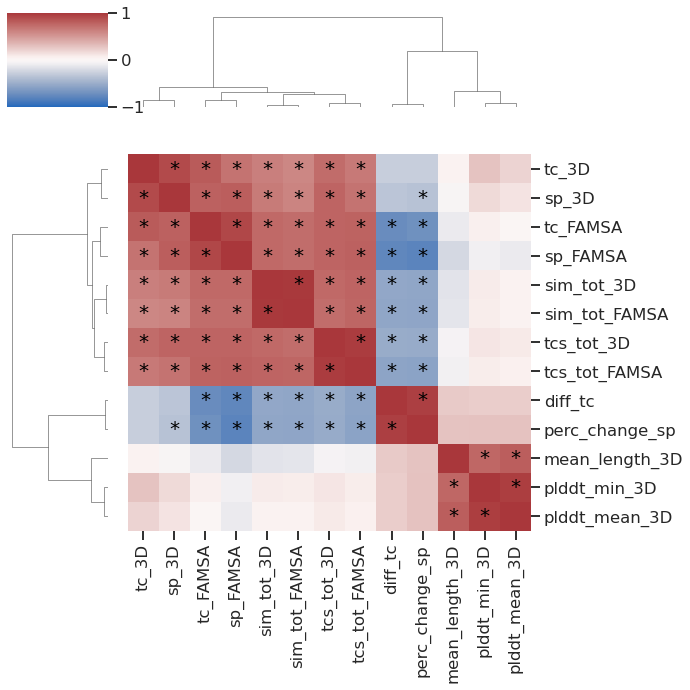

In [235]:

df_correlation = df_d_r[["diff_tc","tc_3D","tc_FAMSA","sp_3D","sp_FAMSA", "mean_length_3D", "plddt_min_3D", "plddt_mean_3D", "sim_tot_3D", "tcs_tot_3D", "sim_tot_FAMSA", "tcs_tot_FAMSA", "perc_change_sp"]]

#df_correlation.columns = ["diff_tc", "tc_structure", "tc_nostructure", "n_sequences_family", "mean_length", "plddt_mean"]
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)

# GDT and plddt concordance
In this first part I check the overall metrics, across families
to investigate if there is any general, potentially worrying trend
later on I will focus on the smaller set, which is problematic
to see what we can see there

In [236]:
gdt_summary_ts  = gdt_summary[gdt_summary["metric"] == "GDT-TS"]
gdt_summary_ts["value"] = gdt_summary_ts["value"] * 100

/tmp/ipykernel_37384/1071311822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdt_summary_ts["value"] = gdt_summary_ts["value"] * 100


In [237]:
gdt_vs_plddt = summary_ref_af2.merge(gdt_summary_ts, on = ["family", "sequence"])
gdt_vs_plddt = gdt_vs_plddt[gdt_vs_plddt.family.isin(familes_no_loss)]

In [238]:
gdt_vs_plddt[["plddt", "value"]].corr
print(stats.pearsonr(gdt_vs_plddt.plddt, gdt_vs_plddt.value))
print(stats.spearmanr(gdt_vs_plddt.plddt, gdt_vs_plddt.value))

(0.05283266362324836, 0.21150183454585433)
SpearmanrResult(correlation=0.280188288369344, pvalue=1.4049468973721751e-11)


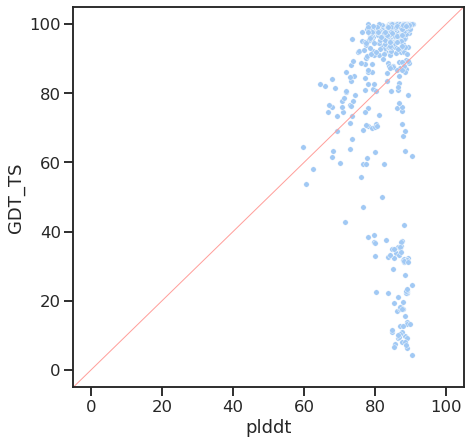

In [239]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=gdt_vs_plddt, x="plddt", y="value", s = 30)
ax.set(ylabel = "GDT_TS")
#.set(xlim=(0,100),ylim=(0,1))
ax.axline((0, 0), (100, 100), linewidth=1, color='r')

[Text(0.5, 0, 'Spearman coefficient (plddt vs GDT_TS)')]

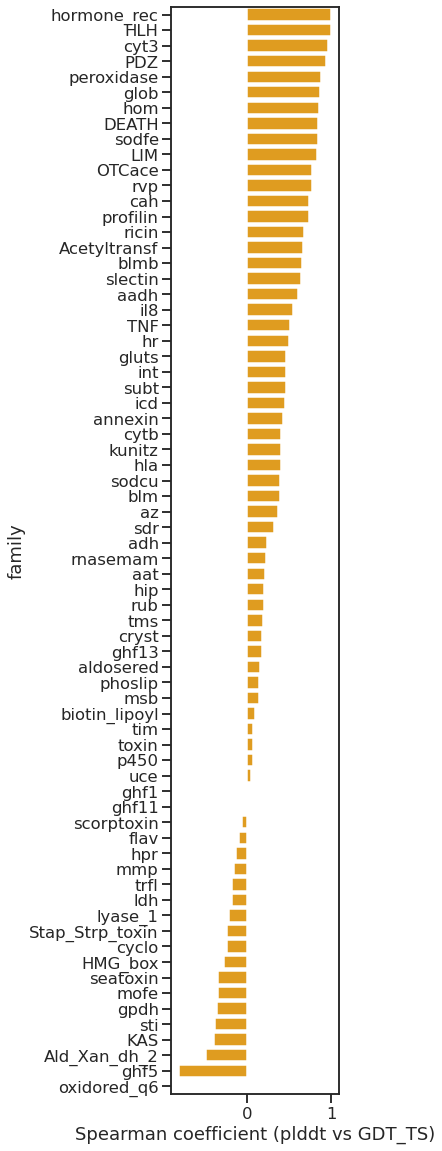

In [240]:
# Check the distibution of the correlations across families

df = pd.DataFrame(gdt_vs_plddt.groupby("family")[["plddt", "value"]].corr().unstack().iloc[:,1])
#df.columns =["family", "corr"]
df = df.reset_index()
df.columns = ["family", "corr"]
df = df.merge(msa_qualities, on = ["family"])

plt.figure(figsize=(3,20))
#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)

df = df.sort_values(by = "corr", ascending = False)
ax= sns.barplot(x='corr', y='family', data=df, ci=None, dodge = False, color = "orange")
ax.set(xlabel='Spearman coefficient (plddt vs GDT_TS)')



### Check general expectations



In [241]:
#x_vars = ["sim_tot_3D", "tcs_tot_3D","plddt_max_3D", "gdt_mean"]
x_vars = ["plddt_min_3D", "tcs_tot", "gdt_min"]
#x_vars = ["plddt_min_FAMSA", "plddt_mean_FAMSA", "plddt_max_FAMSA"]
#x_vars = ["gdt_min", "gdt_mean", "gdt_max"]
y_vars = ["sp_3D", "tc_3D"]
assay_combos = list(itertools.product(x_vars, y_vars))
df_d_r_wgdt["name"] = df_d_r_wgdt["name_3D"]
df_d_r_wgdt_tcs = pd.merge(df_d_r_wgdt,tcs_df, on = "name")
df_d_r_wgdt_tcs["tcs_tot"] = df_d_r_wgdt_tcs["tcs_tot"].astype(float)

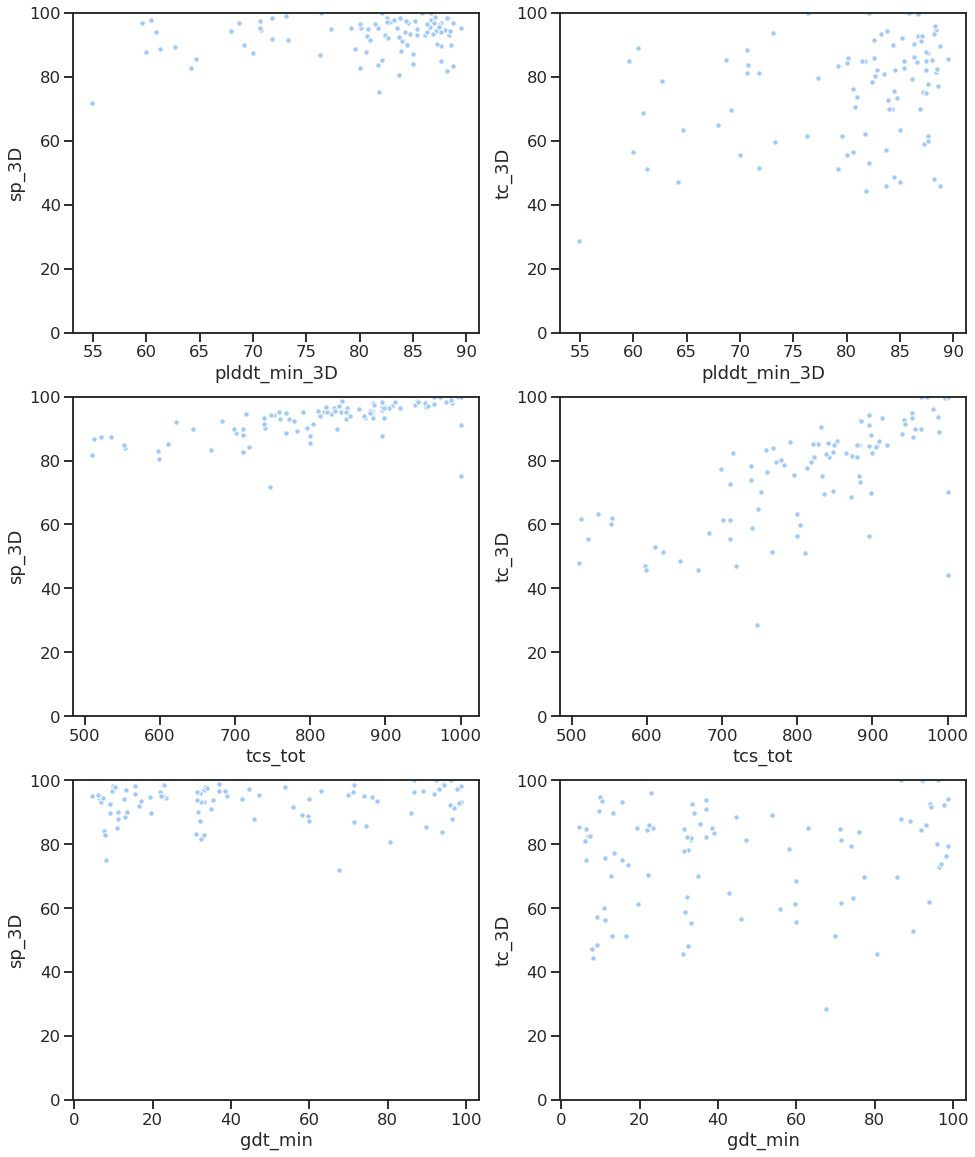

In [242]:
sns.set_theme(style="ticks", palette="pastel")
sns.set_context("talk")
fig, axes = plt.subplots(3, 2, figsize=(16,20))

def scatter_bench(x,y,i,j, legend = False):
    g = sns.scatterplot(ax=axes[i, j],data = df_d_r_wgdt_tcs, x=x, y=y,  \
                         linewidth = 1, s = 30, legend = legend)
    #g.axline((0, 0), (100, 100), linewidth=1, color='r')
    g.set(ylim=(0,100))

    if(legend == True):
        g.legend(bbox_to_anchor=(0.7, 1.35), borderaxespad=0, fontsize='x-large')

assay = 0 
for i in range(0,3):
    for j in range (0,2): 
        scatter_bench(assay_combos[assay][0], assay_combos[assay][1], i,j)
        assay += 1


# Check for the families where we are doing worse 

In [243]:
df_d_r_wgdt["diff_sp"] = df_d_r_wgdt["diff_sp"].astype(float)
problematic_families = df_d_r_wgdt[df_d_r_wgdt.diff_sp < 0]
problematic_families.family.count()

18

In [244]:
df_d_r_wgdt[df_d_r_wgdt.family == "cryst"][["sp_3D", "sp_FAMSA", "diff_sp"]]

,sp_3D,sp_FAMSA,diff_sp
0,87.8,90.2,-2.4


In [245]:
set(problematic_families.family)

{'ChtBD',
 'HLH',
 'LIM',
 'adh',
 'bowman',
 'cryst',
 'hr',
 'ins',
 'int',
 'mmp',
 'msb',
 'myb_DNA-binding',
 'oxidored_q6',
 'phc',
 'serpin',
 'tgfb',
 'tms',
 'toxin'}

In [223]:
df_d_r_wgdt[df_d_r_wgdt.diff_sp < 0]["diff_sp"]

0     -2.4
8     -1.4
10    -3.9
11    -0.2
15    -0.5
16    -1.1
19    -1.0
30    -2.8
33    -5.7
36    -6.2
42    -0.2
44    -1.0
46    -0.5
48   -25.9
52    -1.1
55    -2.3
62    -0.7
86    -0.8
Name: diff_sp, dtype: float64

# Extract the minimum TCS

In [246]:
# ---------------------------------------------------------
# Get TCS (and store for future notebooks) 
# ---------------------------------------------------------
tcss = os.path.join(evaluation_dir,"homfam/evaluation/tcs/*.tcs")
tcss_3d = os.path.join(evaluation_dir,"homfam/alignments/*/*/*.tcs")
#tcs_paths = list(glob.glob(tcss)) + list(glob.glob(tcss_3d))
tcs_paths = list(glob.glob(tcss))

In [247]:
tcs_df_complete = pd.DataFrame()
for file in tcs_paths:
    full_name = file.split(sep = "/")[-1].replace(".tcs", "")
    source = file.split(sep = "/")[-3]
    file_opened = open(file, "r")
    #tot_line = [line.split(sep = ":") for line in file_opened if line.contains(':')]
    for line in file_opened: 
        if ":" in line and "CPU" not in line: 
            s_line = line.split(sep = ":")
            seq = [s_line[0].strip()]
            if seq != "cons": 
                entry = pd.DataFrame({'name_3D':[full_name], 'sequence': seq,"tcs": s_line[1].strip(), "source":source})
                tcs_df_complete =  pd.concat([tcs_df_complete, entry], ignore_index = True)
tcs_df_complete["method"] = tcs_df_complete.name_3D.str.split(".", expand = True)[2]
tcs_df_complete["family"] = tcs_df_complete.name_3D.str.split(".", expand = True)[0].str.split("-",expand=True)[0]


## Explore TCS concordance btw FAMSA and 3D, across families and across the problematic families 

In [248]:
tcs_df_famsa = tcs_df_complete[tcs_df_complete.method == "PROBAPAIR"]
tcs_df_3d = tcs_df_complete[tcs_df_complete.method == "3DCOFFEE"]

tcs_df = tcs_df_3d.merge(tcs_df_famsa, on = ["family", "sequence"])
tcs_df.tcs_y = tcs_df.tcs_y.astype(float)
tcs_df.tcs_x = tcs_df.tcs_x.astype(float)
tcs_df = tcs_df.rename( columns = { "tcs_x": "tcs_3D", "tcs_y": "tcs_probapair", "name_3D_x": "name_3D"})
#tcs_df = tcs_df.merge(tcs_df_exp, on = ["family", "sequence"])

#tcs_df.merge(tcs_df_exp, on = ["family", "sequence"])

problematic_families_list = problematic_families.family.to_list()
tcs_df["problematic"] = "NO"
tcs_df["problematic"][tcs_df.family.isin(problematic_families_list)] = "YES"

/tmp/ipykernel_37384/3211084502.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcs_df["problematic"][tcs_df.family.isin(problematic_families_list)] = "YES"


In [249]:
tcs_df = tcs_df.merge(df_d_r, on = ["name_3D", "family"])

In [250]:
len(set(tcs_df.family))

91

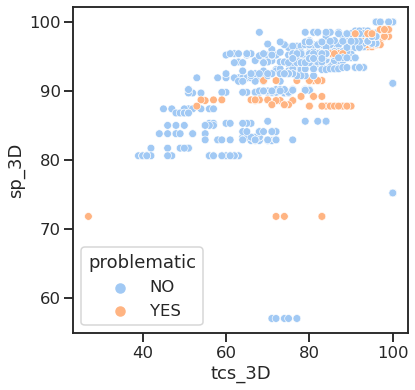

In [251]:
plt.figure(figsize=(6,6))
ax = sns.scatterplot(data = tcs_df, x = "tcs_3D", y="sp_3D",s = 60, alpha = 1,  hue = "problematic")

# How well the tcs of probapair correlate with 3D+AF2? 

## It correlates quite well and the problematic ones are mostly not concordant

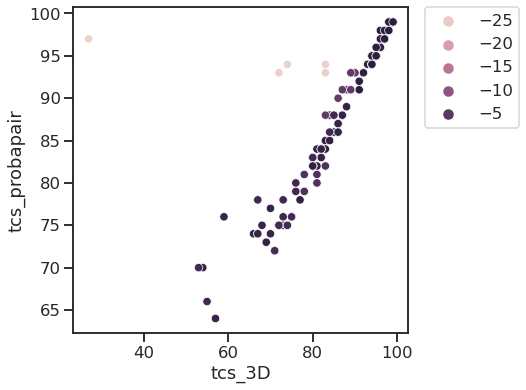

In [253]:
# Per sequence

plt.figure(figsize=(6,6))
tcs_df_prob = tcs_df[tcs_df.family.isin(problematic_families.family)]
tcs_df["diff_sp"] = tcs_df["diff_sp"].astype(float)
ax = sns.scatterplot(data = tcs_df_prob, x = "tcs_3D", y="tcs_probapair",s = 70, alpha = 1, hue = "diff_sp")
#ax.axline((0, 0), (100, 100), linewidth=1, color='grey', linestyle = "--")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


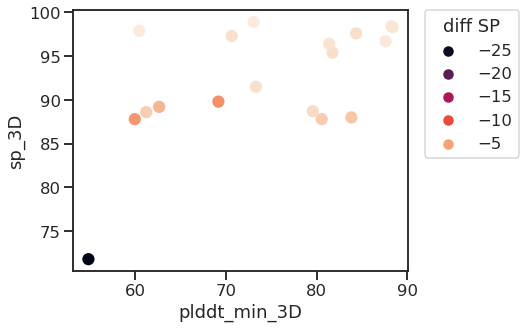

In [173]:
min_tcs = pd.DataFrame(tcs_df_complete.groupby(by = "name_3D")["tcs"].min()).reset_index()
min_tcs = min_tcs.rename(columns={'tcs': 'min_tcs'})
min_tcs = min_tcs.astype({'min_tcs':'int'})

df = pd.merge(df_d_r_wgdt, min_tcs, on = "name_3D")
df["problematic_family"] = "ok"
df.loc[df.diff_sp < 0, 'problematic_family'] = "problematic"
df = df[df.family.isin(problematic_families.family)]


# 1. Expectations: TCS vs SP
plt.figure(figsize=(6,4.8))

x_var = "gdt_min"
x_var = "plddt_min_3D"

y_var = "sp_3D"
hue_var = "diff_sp"

sns.scatterplot(data = df, x = x_var, y = y_var, hue= hue_var, \
                edgecolor = "grey", linewidth = 0, palette = "rocket", s = 150)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "diff SP")


## Are the same sequences having the low plddt the ones being the problem in TCS? 


In [174]:
tcs_df_complete = tcs_df_complete.astype({'sequence':'str'})
tcs_df_complete = tcs_df_complete.astype({'tcs':'int'})
summary_ref_af2 = summary_ref_af2.astype({'sequence':'str'})
df = pd.merge(tcs_df_complete, summary_ref_af2, on = "sequence" )
df[["family", "method", "align_method", "tree_method"]] = df.name_3D.str.split(".", expand = True)
df = df[df.align_method == "3DCOFFEE"]
df["family"] = df.family.str.split("-ref", expand = True)[0]
df = df.merge(gdt_summary, on = ["family", "sequence"])

df["problematic"] = "NO"
df["problematic"][df.family.isin(problematic_families_list)] = "YES"

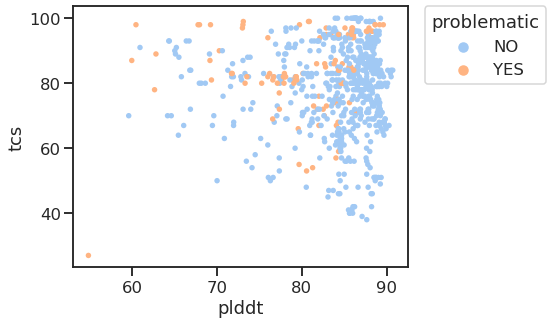

In [187]:
# 1. Expectations: TCS vs SP
plt.figure(figsize=(6,4.8))

x_var = "plddt"
y_var = "tcs"
hue_var = "problematic"
df = df[df.metric ==  "GDT-TS"]
sns.scatterplot(data = df, x = x_var, y = y_var, hue= hue_var, \
                edgecolor = "grey", linewidth = 0,  s = 30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "problematic")


# TCS workflow

In [3]:
# From CSV parse in df the results of the tcs workflow
def get_df_tcs_wf(file): 
    df = pd.read_csv(file, header = None)
    df[["sequence", "tcs_seq"]] = df[1].str.split(":", expand = True)
    df = df.rename(columns = { 0: "tcs", 2: "iteration", 3:"sp", 4:"tc"})
    df = df.drop([1], axis = 1)
    df["method"] = file.split("/")[-1].split("_tcs")[0]
    df["family"] = df.method.str.split(".", expand = True)[0]
    df["approach"] = df.method.str.split(".", expand = True)[2]
    return(df)


# TCS optimization workflow
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
tcs_wfs = os.path.join(evaluation_dir,"homfam/evaluation/tcs_optimization_removestructure/*/*/*_tcsoptimization_summary.csv")
tcs_paths = list(glob.glob(tcs_wfs))

# Extract and store all TCS WF results
tcs_wf_summary = pd.DataFrame()
for file in tcs_paths: 
    tcs_wf_summary = pd.concat([tcs_wf_summary, get_df_tcs_wf(file)])
tcs_wf_summary["family"] = tcs_wf_summary.family.str.split("-ref", expand=True)[0]

In [4]:
tcs_wf_summary_3D = tcs_wf_summary[tcs_wf_summary.approach == "3DCOFFEE"]

In [5]:
tcs_wf_summary_3D[tcs_wf_summary_3D.family == "bowman"]

,tcs,iteration,sp,tc,sequence,tcs_seq,method,family,approach
0,746,1,71.8,28.6,-,-,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE
1,897,2,87.8,68.6,1sbwi,27.0,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE
2,946,3,95.9,82.9,1tabi,83.0,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE
3,948,4,97.7,90.0,1bbi,93.0,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE
4,948,5,97.7,90.0,1pbia,93.0,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE
5,948,6,97.7,90.0,1pi2,94.0,bowman-ref.progressive.3DCOFFEE.MBED,bowman,3DCOFFEE


In [10]:
problematic_families_list = list(["bowman"])

In [11]:
tcs_wf_summary_3D_prob = tcs_wf_summary_3D[tcs_wf_summary_3D.family.isin(problematic_families_list)]
tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.iteration < 4]
#tcs_wf_summary_3D_prob.merge(df_ref_proba, on = ["family"], how = "left").head(2)
tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob[["family", "sp", "iteration"]]

In [12]:
df_prob_ref = df_prog_3d_probapair_mbed[["family", "sp"]]
df_prob_ref["iteration"] = 0
tcs_wf_summary_3D_prob = pd.concat([tcs_wf_summary_3D_prob,df_prob_ref])

NameError: name 'df_prog_3d_probapair_mbed' is not defined

NameError: name 'titles' is not defined

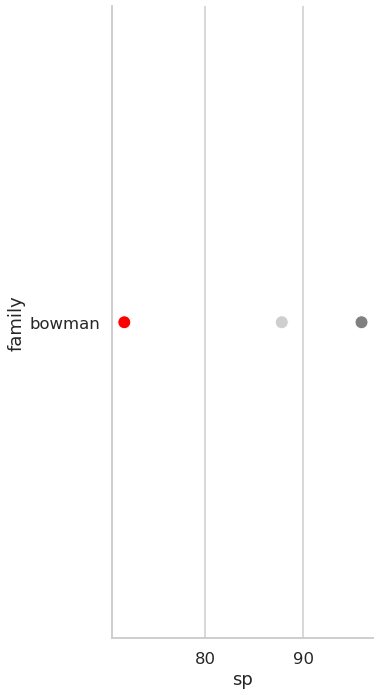

In [13]:
#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)
sns.set_theme(style="whitegrid")
sns.set_context("talk")

tcs_wf_summary_3D_prob = tcs_wf_summary_3D_prob.sort_values(by = "iteration", ascending = False)


sorter = tcs_wf_summary_3D_prob[tcs_wf_summary_3D_prob.iteration == 1].sort_values("sp").family.to_frame()
tcs_wf_summary_3D_prob_sorted = pd.merge(sorter,tcs_wf_summary_3D_prob, on = "family", how = 'left')

# Create an array with the colors you want to use
colors = ["red", "#CECECE", "grey", "#545454"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))


g = sns.PairGrid(tcs_wf_summary_3D_prob_sorted,
                 x_vars="sp", y_vars=["family"], hue = "iteration",
                 height=10, aspect=0.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=13, orient="h", jitter=False,
       linewidth=1, edgecolor="w")


for ax, title in zip(g.axes.flat, titles):
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "iteration")

